In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os

%matplotlib inline

--- 

Данная тетрадка сочетает в себе среду разработки и для демонстрации. Ниже приведен код разработки, демонстрация располагается в самом конце тетрадки. Необходимо воспроизвести все ячейки подряд (щелкать shift+enter) от первой до демонстрации. 

## Helping Routines

In [2]:
def show(img, figsize=(4, 4)):
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation="bicubic")
    plt.xticks([]), plt.yticks([])
    plt.show()
    
def cv2show(img):
    cv2.imshow("img", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

---

## Loading the data

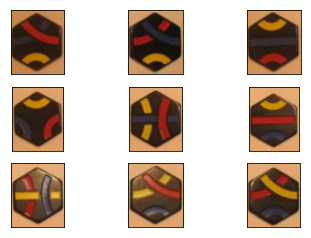

In [5]:
def plot_samples_in_grid(path, num):
    f, axarr = plt.subplots(num, num)
    for k, img_name in enumerate(os.listdir(path)[:num**2]):
        img = cv2.imread(path+img_name, cv2.IMREAD_COLOR)
        axarr[k//num, k%num].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation="bicubic")
        axarr[k//num, k%num].set_xticks([])
        axarr[k//num, k%num].set_yticks([])
    plt.show()

plot_samples_in_grid("data/train/", 3)

In [6]:
def decompose_by_channels(path):
    data = {"H": np.uint8([]), "S": np.uint8([]), "V": np.uint8([])}
    for img_name in os.listdir(path):
        #print(img_name)
        im = cv2.imread(path+img_name, cv2.IMREAD_COLOR)
        for name, channel in zip(["H", "S", "V"], cv2.split(cv2.cvtColor(im, cv2.COLOR_BGR2HSV))):
            data[name] = np.append(data[name], channel.reshape(channel.shape[0]*channel.shape[1]))
    return data

Load sample coins

In [7]:
coins = []
for i in range(1, 11):
    coins.append(cv2.imread("data/train/%d.png"%i, cv2.IMREAD_COLOR))

Load non-coins

In [8]:
non_coins = []
for i in range(1, 10):
    non_coins.append(cv2.imread("data/non-coins/non_%d.png"%i, cv2.IMREAD_COLOR))

Load color samples

In [9]:
R = decompose_by_channels("data/R/")
Y = decompose_by_channels("data/Y/")
B = decompose_by_channels("data/B/")
Bg = decompose_by_channels("data/bg/")
D = decompose_by_channels("data/D/")

## Color Analysis

### Red

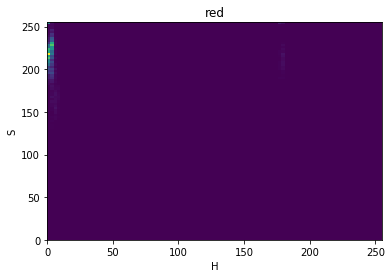

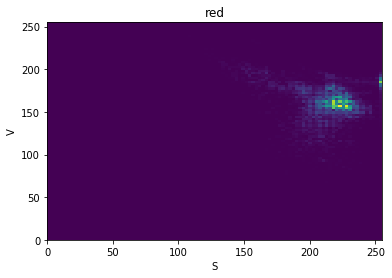

In [10]:
plt.hist2d(R["H"], R["S"], bins=100, range=[[0, 255], [0, 255]])
plt.xlabel("H")
plt.ylabel("S")
plt.title("red")
plt.show()
plt.hist2d(R["S"], R["V"], bins=100, range=[[0, 255], [0, 255]])
plt.xlabel("S")
plt.ylabel("V")
plt.title("red")
plt.show()

### Yellow

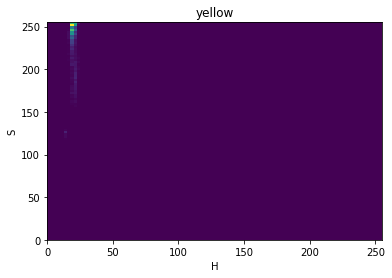

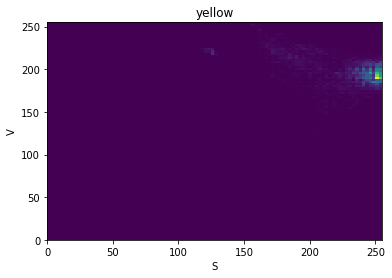

In [11]:
plt.hist2d(Y["H"], Y["S"], bins=100, range=[[0, 255], [0, 255]])
plt.xlabel("H")
plt.ylabel("S")
plt.title("yellow")
plt.show()
plt.hist2d(Y["S"], Y["V"], bins=100, range=[[0, 255], [0, 255]])
plt.xlabel("S")
plt.ylabel("V")
plt.title("yellow")
plt.show()

### Blue

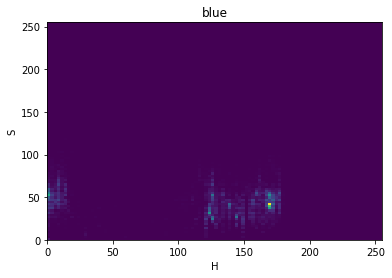

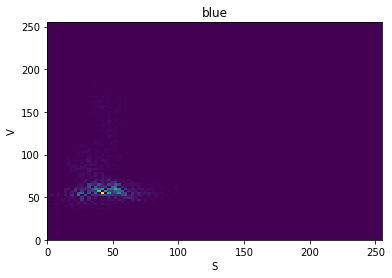

In [12]:
plt.hist2d(B["H"], B["S"], bins=100, range=[[0, 255], [0, 255]])
plt.xlabel("H")
plt.ylabel("S")
plt.title("blue")
plt.show()
plt.hist2d(B["S"], B["V"], bins=100, range=[[0, 255], [0, 255]])
plt.xlabel("S")
plt.ylabel("V")
plt.title("blue")
plt.show()

Basing on the abovelisted histograms, we can estimate limits for all colors in HSV space

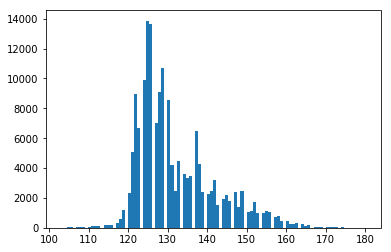

In [13]:
plt.hist(Bg["S"], bins=100)
plt.show()

In [14]:
low_yellow = np.array([13, 140, 150]) #ok!
high_yellow = np.array([ 25, 255, 255]) #ok!
low_red = np.array([0, 110, 110]) #ok 
high_red = np.array([10, 255, 255]) #ok
low_blue = np.array([100, 0, 25]) #ok 
high_blue = np.array([180, 100, 175]) #ok
low_blue_2 = np.array([0, 0, 25]) #ok
high_blue_2 = np.array([25, 100, 175]) #ok
low_bg = np.array([12, 110, 180])#np.array([40, 100, 170])
high_bg = np.array([16, 200, 255])#np.array([255, 255, 255])
low_dark = np.array([0, 50, 0])
high_dark = np.array([25, 200, 150])

---

## Segmentation

In [15]:
def get_segments_markers(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img, low_bg, high_bg)
    res = cv2.bitwise_and(img, img, mask=mask)
    gray = cv2.cvtColor(cv2.cvtColor(res,cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((10,10),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 3)
    sure_fg = cv2.dilate(opening,kernel,iterations=1)
    sure_bg = cv2.bitwise_not(cv2.dilate(opening,kernel, iterations=15))
    unknown = cv2.bitwise_and(cv2.bitwise_not(sure_bg), cv2.bitwise_not(sure_fg))
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers+1
    markers[unknown==255] = 0
    return cv2.watershed(img,markers)

---

## Feature Extraction 

In [23]:
def extract_objects_from_segment(img_segment):
    img_segment = cv2.cvtColor(img_segment, cv2.COLOR_BGR2HSV)
    mask = cv2.bitwise_not(cv2.inRange(img_segment, low_bg, high_bg))
    segment_wo_bg = cv2.bitwise_and(img_segment, img_segment, mask=mask)
    segment_wo_bg = cv2.cvtColor(segment_wo_bg, cv2.COLOR_HSV2BGR)
    median = cv2.medianBlur(segment_wo_bg, 7)
    gray = cv2.cvtColor(median, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)
    image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    fragments = []
    for contour in contours:
        cntr_x = contour.T[0][0]
        cntr_y = contour.T[1][0]
        center_y = int((min(cntr_y) + max(cntr_y))/2)
        center_x = int((min(cntr_x)+max(cntr_x))/2)
        fragment = median[min(cntr_y):max(cntr_y),min(cntr_x):max(cntr_x), :]
        if fragment.shape[0] == 0 or fragment.shape[1] == 0:
            continue
        fragments.append(((center_x, center_y), cv2.resize(fragment, (100, 100))))
    return fragments

In [17]:
def extract_colour_features(img):
    fragment_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    red_mask = cv2.inRange(fragment_hsv, low_red, high_red)
    red_fragment = cv2.bitwise_and(fragment_hsv, fragment_hsv, red_mask)
    yellow_mask = cv2.inRange(fragment_hsv, low_red, high_red)
    yellow_fragment = cv2.bitwise_and(fragment_hsv, fragment_hsv, yellow_mask)
    blue_mask = cv2.bitwise_or(cv2.inRange(fragment_hsv, low_blue, high_blue),
                                        cv2.inRange(fragment_hsv, low_blue_2, high_blue_2))
    blue_fragment = cv2.bitwise_and(fragment_hsv, fragment_hsv, blue_mask)
    red_fragment_smooth = cv2.cvtColor(cv2.medianBlur(cv2.cvtColor(red_fragment, cv2.COLOR_HSV2BGR), 7), cv2.COLOR_BGR2HSV)
    blue_fragment_smooth = cv2.cvtColor(cv2.medianBlur(cv2.cvtColor(blue_fragment, cv2.COLOR_HSV2BGR), 7), cv2.COLOR_BGR2HSV)
    yellow_fragment_smooth = cv2.cvtColor(cv2.medianBlur(cv2.cvtColor(yellow_fragment, cv2.COLOR_HSV2BGR), 7), cv2.COLOR_BGR2HSV)
    red_pixels = sum(sum(cv2.inRange(red_fragment_smooth, low_red, high_red) == 255))
    yellow_pixels = sum(sum(cv2.inRange(yellow_fragment_smooth, low_yellow, high_yellow) == 255))
    blue_pixels = sum(sum(cv2.bitwise_or(cv2.inRange(blue_fragment_smooth, low_blue, high_blue),
                                        cv2.inRange(blue_fragment_smooth, low_blue_2, high_blue_2)) == 255))
    all_coloured_pixels = red_pixels + yellow_pixels + blue_pixels
    if all_coloured_pixels == 0:
        all_coloured_pixels = 1
    return np.array([red_pixels/all_coloured_pixels, 
                yellow_pixels/all_coloured_pixels, 
                blue_pixels/all_coloured_pixels, all_coloured_pixels/(100*100)])

In [18]:
def get_contours_count(img, color_mask):
    obj_hsv = cv2.cvtColor(obj, cv2.COLOR_BGR2HSV)
    line = cv2.cvtColor(cv2.bitwise_and(obj_hsv, obj_hsv, mask=color_mask), cv2.COLOR_HSV2BGR)
    line_median = cv2.medianBlur(line, 15)
    gray = cv2.cvtColor(line_median, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)
    image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    return len(contours)

---

## Generate dataset for coins detection

In [24]:
X = []
objs = []
coins_ctr = 0
for img in coins:
    markers = get_segments_markers(img)
    segment_num = markers.max()
    for j in range(segment_num+1):
        img_segment = img.copy()
        img_segment[markers != j] = [0, 0, 0]
        for coord, obj in extract_objects_from_segment(img_segment):
            objs.append(obj)
            features = np.array([])
            features = np.append(features, extract_colour_features(obj))
            obj_hsv = cv2.cvtColor(obj, cv2.COLOR_BGR2HSV)
            red_mask = cv2.inRange(obj_hsv, low_red, high_red)
            yellow_mask = cv2.inRange(obj_hsv, low_yellow, high_yellow)
            blue_mask = cv2.bitwise_or(cv2.inRange(obj_hsv, low_blue, high_blue),
                                     cv2.inRange(obj_hsv, low_blue_2, high_blue_2))
            features = np.append(features, 2/(get_contours_count(obj, red_mask) + 1))
            features = np.append(features, 2/(get_contours_count(obj, yellow_mask) + 1))
            features = np.append(features, 2/(get_contours_count(obj, blue_mask) + 1))
            X.append(features)
            
            coins_ctr +=1 
X = X[1:]
objs = objs[1:]
coins_ctr -= 1
            
non_coins_ctr = 0
for img in non_coins:
    markers = get_segments_markers(img)
    segment_num = markers.max()
    for j in range(segment_num+1):
        img_segment = img.copy()
        img_segment[markers != j] = [0, 0, 0]
        for coord, obj in extract_objects_from_segment(img_segment):
            objs.append(obj)
            features = np.array([])
            features = np.append(features, extract_colour_features(obj))
            obj_hsv = cv2.cvtColor(obj, cv2.COLOR_BGR2HSV)
            red_mask = cv2.inRange(obj_hsv, low_red, high_red)
            yellow_mask = cv2.inRange(obj_hsv, low_yellow, high_yellow)
            blue_mask = cv2.bitwise_or(cv2.inRange(obj_hsv, low_blue, high_blue),
                                     cv2.inRange(obj_hsv, low_blue_2, high_blue_2))
            features = np.append(features, 2/(get_contours_count(obj, red_mask)+1))
            features = np.append(features, 2/(get_contours_count(obj, yellow_mask)+1))
            features = np.append(features, 2/(get_contours_count(obj, blue_mask) + 1))
            non_coins_ctr += 1
            X.append(features)
            
Y = np.array([1]*coins_ctr + [0]*non_coins_ctr)

---

## Learn to recognize coins

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

/Users/aksholokhov/.anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
alg1 = LogisticRegression()
alg2 = RandomForestClassifier()

In [27]:
np.mean(cross_val_score(alg1, X, Y))

0.77508417508417515

In [28]:
np.mean(cross_val_score(alg2, X, Y))

0.93939393939393945

In [29]:
alg2.fit(X, Y)
is_it_coin = alg2

---

## Create feature detection routine

In [37]:
def generate_features(img):
    X = []
    objs = []
    coords = []
    markers = get_segments_markers(img)
    segments_num = markers.max()
    for j in range(segments_num+1):
        img_segment = img.copy()
        img_segment[markers != j] = [0, 0, 0]
        for coord, obj in extract_objects_from_segment(img_segment):
            features = np.array([])
            color_features = extract_colour_features(obj)
            features = np.append(features, color_features)
            obj_hsv = cv2.cvtColor(obj, cv2.COLOR_BGR2HSV)
            red_mask = cv2.inRange(obj_hsv, low_red, high_red)
            yellow_mask = cv2.inRange(obj_hsv, low_yellow, high_yellow)
            blue_mask = cv2.bitwise_or(cv2.inRange(obj_hsv, low_blue, high_blue),
                                     cv2.inRange(obj_hsv, low_blue_2, high_blue_2))
            features = np.append(features, 2/(1+get_contours_count(obj, red_mask)))
            features = np.append(features, 2/(1+get_contours_count(obj, yellow_mask)))
            features = np.append(features, 2/(1+get_contours_count(obj, blue_mask)))
            if is_it_coin.predict(features.reshape(1, -1)):
                objs.append(obj)
                X.append(features)
                coords.append(coord)
    return X, objs, coords

---

## Демонстрация

* подсчет фишек
* тип дуг на фишке
* номер фишки
* аннтоация фишек

In [38]:
class AnnotatedCoin:
    
    edges = {
        1: "Длинная красная дуга малой кривизны, длинная синяя дуга малой кривизны, короткая желтая дуга большой кривизны",
        2: "Короткая красная дуга большой кривизны, прямолинейный синий сегмент, короткая желтая дуга большой кривизны",
        3: "Короткая красная дуга большой кривизны, короткая синяя дуга большой кривизны, короткая желтая дуга большой кривизны",
        4: "Длинная красная дуга малой кривизны, длинная желтая дуга малой кривизны, прямолинейный синий сегмент",
        5: "Короткая желтая дуга малой кривизны, прямолинейный красный сегмент, короткая синяя дуга малой кривизны",
        6: "Длинная красная дуга малой кривизны, длинная синяя дуга малой кривизны, прямолинейный желтый сегмент",
        7: "Длинная красная дуга малой кривизны, длинная желтая дуга малой кривизны,  короткая синяя дуга большой кривизны",
        8: "Длинная красная дуга малой кривизны, длинная желтая дуга малой кривизны, короткая синяя дуга большой кривизны",
        9: "Прямолинейный красный сегмент, длинная желтая дуга малой кривизны, длинная синяя дуга малой кривизны",
        10: "Длинная красная дуга малой кривизны, длинная синяя дуга малой кривизны, короткая желтая дуга большой кривизны"
        
    }
    
    def __init__(self, img, train_samples):
        self.__img = img
        X, objs, coords = generate_features(img)
        self.__X = X
        self.__objs = objs
        self.__coords = coords
        self.__ts = train_samples

    def count_coins(self):
        return len(self.__X)

    def get_image(self):
        result = img.copy()
        for obj, x, coord in zip(self.__objs, self.__X, self.__coords):
            closest = np.argmin([np.linalg.norm(x - y) for y in self.__ts[:10]])+1
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(result,'%d'%closest,coord, font, 1,(255,255,255),2,cv2.LINE_AA)
        return result
    
    def get_coin_type(self):
        if len(self.__X) > 1:
            raise Exception("There are more than one coin on this picture :(")
        x = self.__X[0]
        return np.argmin([np.linalg.norm(x - y) for y in self.__ts[:10]])+1
    
    def get_edges(self):
        k = self.get_coin_type()
        return self.edges[k] 

10 coins


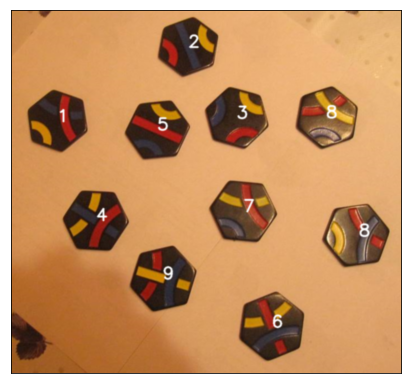

In [39]:
img = cv2.imread("data/samples/Group_4.bmp", cv2.IMREAD_COLOR)
annotated = AnnotatedCoin(img, X)
print("%d coins"%annotated.count_coins())
show(annotated.get_image(), figsize=(7, 7))

3 coins


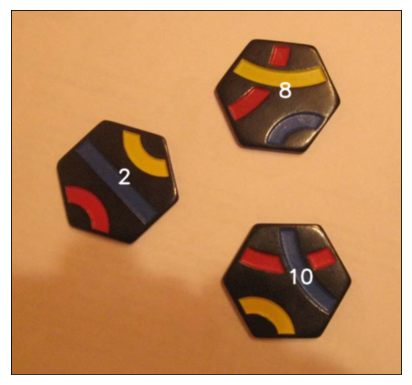

In [40]:
img = cv2.imread("data/samples/Group_1.bmp", cv2.IMREAD_COLOR)
annotated = AnnotatedCoin(img, X)
print("%d coins"%annotated.count_coins())
show(annotated.get_image(), figsize=(7, 7))

3 coins


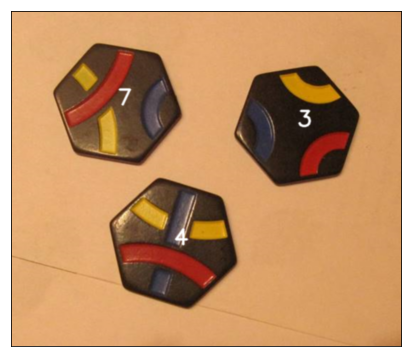

In [41]:
img = cv2.imread("data/samples/Group_2.bmp", cv2.IMREAD_COLOR)
annotated = AnnotatedCoin(img, X)
print("%d coins"%annotated.count_coins())
show(annotated.get_image(), figsize=(7, 7))

1 coins
Длинная красная дуга малой кривизны, длинная синяя дуга малой кривизны, короткая желтая дуга большой кривизны
Номер фишки: 10


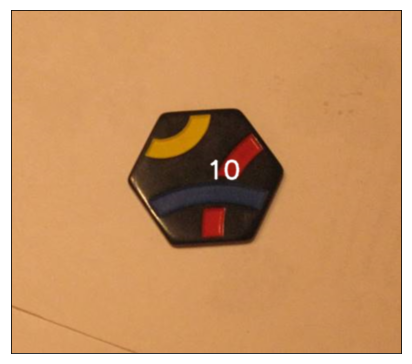

In [42]:
img = cv2.imread("data/samples/Single_1.bmp", cv2.IMREAD_COLOR)
annotated = AnnotatedCoin(img, X)
print("%d coins"%annotated.count_coins())
print(annotated.get_edges())
print("Номер фишки: %d" % annotated.get_coin_type())
show(annotated.get_image(), figsize=(7, 7))

1 coins
Длинная красная дуга малой кривизны, длинная желтая дуга малой кривизны,  короткая синяя дуга большой кривизны
Номер фишки: 7


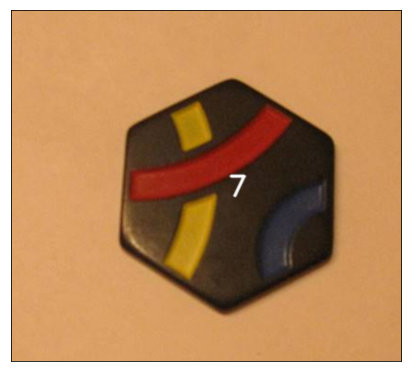

In [43]:
img = cv2.imread("data/samples/Single_2.bmp", cv2.IMREAD_COLOR)
annotated = AnnotatedCoin(img, X)
print("%d coins"%annotated.count_coins())
print(annotated.get_edges())
print("Номер фишки: %d" % annotated.get_coin_type())
show(annotated.get_image(), figsize=(7, 7))

1 coins
Короткая красная дуга большой кривизны, короткая синяя дуга большой кривизны, короткая желтая дуга большой кривизны
Номер фишки: 3


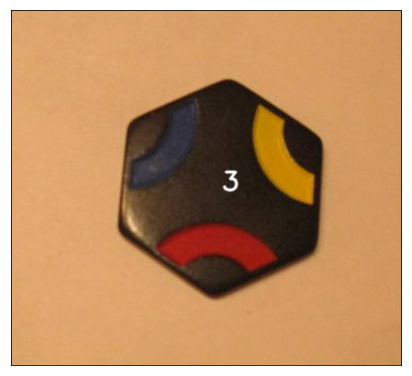

In [44]:
img = cv2.imread("data/samples/Single_3.bmp", cv2.IMREAD_COLOR)
annotated = AnnotatedCoin(img, X)
print("%d coins"%annotated.count_coins())
print(annotated.get_edges())
print("Номер фишки: %d" % annotated.get_coin_type())
show(annotated.get_image(), figsize=(7, 7))